In [1]:
%reload_ext autoreload
%autoreload 2

import logging
import numpy as np

# Make analysis reproducible
np.random.seed(0)

# Enable logging
logging.basicConfig(level=logging.INFO)


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")

In [2]:
from replay_trajectory_classification.sorted_spikes_simulation import make_simulated_run_data

time, position, sampling_frequency, spikes, place_fields = make_simulated_run_data()

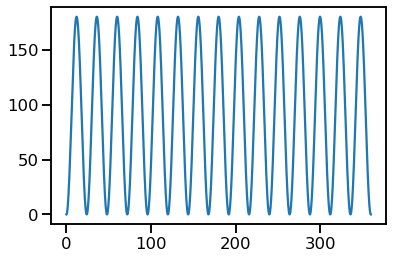

In [3]:
plt.plot(time, position)

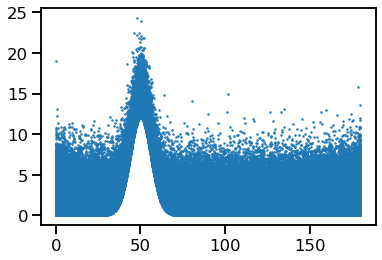

In [47]:
import scipy.stats


max_rate = 12

firing_rate = scipy.stats.multivariate_normal(50, 36).pdf(position)
firing_rate /= firing_rate.max()
firing_rate *= max_rate

calcium_activity = scipy.stats.gamma.rvs(a=2, loc=firing_rate)

plt.scatter(position, calcium_activity, s=1)

In [48]:
from replay_trajectory_classification.calcium_likelihood import make_spline_design_matrix

place_bin_edges = np.linspace(0, 180)[:, np.newaxis]
knot_spacing = 10

design_matrix = make_spline_design_matrix(
    position[:, np.newaxis], place_bin_edges, knot_spacing)

In [49]:
from replay_trajectory_classification.calcium_likelihood import fit_glm

result = fit_glm(calcium_activity, design_matrix, penalty=1E-1)

In [50]:
1 / result.scale

array(2.22977579)

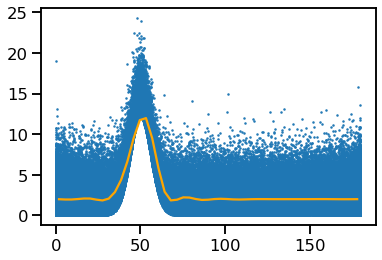

In [51]:
from replay_trajectory_classification.calcium_likelihood import get_activity_rate, make_spline_predict_matrix

place_bin_centers = place_bin_edges[:-1] + np.diff(place_bin_edges, axis=0) / 2

design_info = design_matrix.design_info
predict_matrix = make_spline_predict_matrix(design_info, place_bin_centers)
place_fields = get_activity_rate(predict_matrix, result)

plt.scatter(position, calcium_activity, s=1)
plt.plot(place_bin_centers, place_fields, color='orange', zorder=10)

In [61]:
from statsmodels.api import families

g = families.Gamma(families.links.identity())
log_likelihood = g.loglike_obs(calcium_activity[:, np.newaxis], place_fields[np.newaxis, :], scale=result.scale)


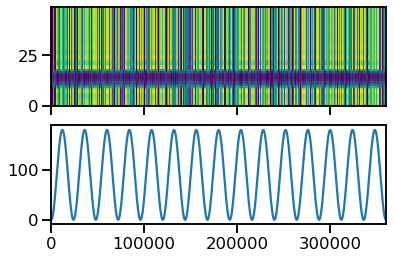

In [69]:
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].pcolormesh(np.exp(log_likelihood).T)
axes[1].plot(position)


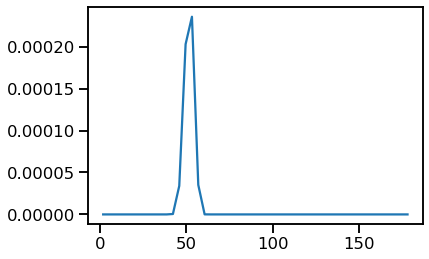

In [100]:
ll = g.loglike_obs(np.asarray([50])[:, np.newaxis], place_fields[np.newaxis, :], scale=result.scale)
plt.plot(place_bin_centers, np.exp(ll.T))

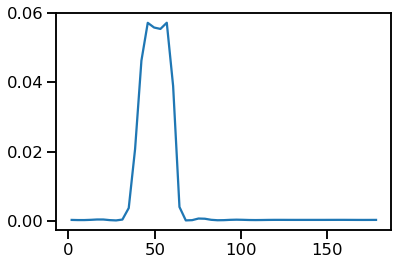

In [110]:
ll = g.loglike_obs(np.asarray([10])[:, np.newaxis], place_fields[np.newaxis, :], scale=result.scale)
plt.plot(place_bin_centers, np.exp(ll.T))

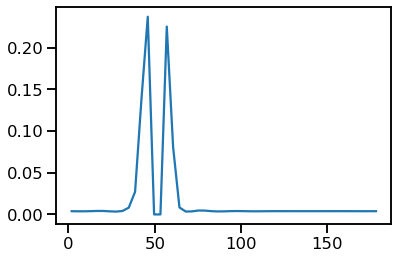

In [111]:
x = np.asarray([10])[:, np.newaxis]
ll2 = scipy.stats.gamma.logpdf(a=1/result.scale, x=x, loc=place_fields[np.newaxis, :])
plt.plot(place_bin_centers, np.exp(ll2.T))

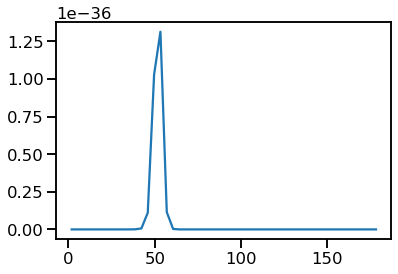

In [112]:
x = np.asarray([100])[:, np.newaxis]
ll2 = scipy.stats.gamma.logpdf(a=1/result.scale, x=x, loc=place_fields[np.newaxis, :])
plt.plot(place_bin_centers, np.exp(ll2.T))

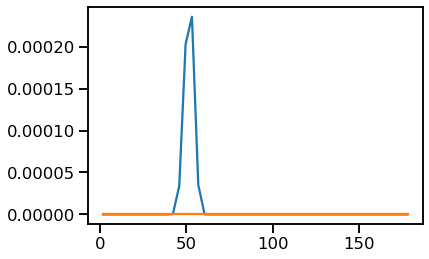

In [85]:
plt.plot(place_bin_centers, np.exp(ll.T))
plt.plot(place_bin_centers, np.exp(ll2.T))

In [115]:
from replay_trajectory_classification.calcium_likelihood import estimate_place_fields

estimate_place_fields(position[:, np.newaxis],
                          calcium_activity[:, np.newaxis],
                          place_bin_centers,
                          place_bin_edges)

(<xarray.DataArray (position: 49, neuron: 1)>
 array([[ 1.99781672],
        [ 1.9624849 ],
        [ 1.96233076],
        [ 2.01653256],
        [ 2.08458819],
        [ 2.0821412 ],
        [ 1.94855411],
        [ 1.84935224],
        [ 2.0712966 ],
        [ 2.87820088],
        [ 4.38318681],
        [ 6.64125104],
        [ 9.48069464],
        [11.73988585],
        [11.98729099],
        [ 9.51572181],
        [ 5.84587508],
        [ 2.92116148],
        [ 1.85474606],
        [ 1.93766353],
 ...
        [ 1.96165389],
        [ 1.97677236],
        [ 2.00048707],
        [ 2.01222746],
        [ 2.01133841],
        [ 2.00623921],
        [ 2.00401594],
        [ 2.00455711],
        [ 2.00541105],
        [ 2.00492521],
        [ 2.00437829],
        [ 2.00571693],
        [ 2.00949909],
        [ 2.01268254],
        [ 2.01167521],
        [ 2.00561041],
        [ 1.99870566],
        [ 1.99566778],
        [ 1.9983177 ],
        [ 2.00454904]])
 Coordinates:
   * position 

In [119]:
np.clip(np.asarray([0.05, 0.1, 0.2]), 0.1, np.inf)

array([0.1, 0.1, 0.2])